In [ ]:
import math
from collections import Counter, defaultdict
from functools import partial
from pprint import pprint

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy import stats #keperluan perhitungan statistik

plt.style.use("fivethirtyeight")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 1. Data Loading & Exploration

Analisis prediktif ini akan membantu memperkirakan apakah seorang pasien dengan informasi kesehatan tertentu memiliki penyakit jantung atau tidak

[Heart Failure Prediction](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease))

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Python Programming/Dataset/heart.csv')

In [ ]:
#Data asli dan data untuk  pemodelan perlu dibedakan
df_for_modelling = df.copy()

In [ ]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
df.shape

(918, 12)

# 2. Exploratory Data Analysis

In [ ]:
#Melihat missing value

df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [ ]:
df.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

In [ ]:
df.describe(include='object')

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [ ]:
# Mengubah type data fastingBS, HeartDisese karena harusnya menjadi 
# Data categorical dengan unik value terdiri dari 2 macam yaitu 0 dan 1

df['FastingBS'] = df['FastingBS'].astype('object')
df['HeartDisease'] = df['HeartDisease'].astype('object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    object 
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    object 
dtypes: float64(1), int64(4), object(7)
memory usage: 86.2+ KB


In [ ]:
numerical_features = df.select_dtypes(include="number").columns.tolist() # memisahkan kolom numerik
categorical_features = df.select_dtypes(include="object").columns.tolist() # memishakan kolom kategorik

print("Numerical features:")
pprint(numerical_features, compact=True) # print untuk tipe data yang lebih kompleks (list, tuple, set, dll)
print("Categorical features:")
pprint(categorical_features, compact=True) # agar memastikan categorical_features tidak berubah ketika  dipanggil lagI

Numerical features:
['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
Categorical features:
['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina',
 'ST_Slope', 'HeartDisease']


In [ ]:
# menampilkan perhitungan stastictics utk data variabel Numerik

df[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2


In [ ]:
# menampilkan perhitungan stastictics utk data variabel Kategorik

df[categorical_features].describe().T

,count,unique,top,freq
Sex,918,2,M,725
ChestPainType,918,4,ASY,496
FastingBS,918,2,0,704
RestingECG,918,3,Normal,552
ExerciseAngina,918,2,N,547
ST_Slope,918,3,Flat,460
HeartDisease,918,2,1,508


##2.2 Exploratory Data Analysis Numerik

**Data Dictionary**:

| column | description |
| ------ | ----------- |
| `Age` | Umur dari pasien |
| `Sex` | Jenis kelamin pasien [F: Female, M: Male] |
| `ChestPainType` |  Tipe nyeri dada [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic] |
| `RestingBP` | Tekanan Darah saat istirahat[mm Hg] |
| `Cholesterol` | Kolestrol serum [mm/dl] |
| `FastingBS` |  Gula darah saat puasa  [1: FastingBS > 120 mg/dL, 0: Sebaliknya] |
| `Resting ECG :` | Pemeriksaan yang dilakukan saat pasien dalam kondisi istirahat (dalam posisi berbaring). |
| `Max HR` |  Mengukur detak jantung maksimum |
| `Exercise Angina` |  Latihan untuk dada karena berkurangnya aliran darah pada jantung |
| `Old peak` | depresi ST yang diakibatkan oleh latihan relative terhadap saat istirahat. |
| `ST_Slope` | Pergeseran terhadap peningkatan denyut jantung yang disebabkan oleh olahraga  |
| `HeartDisease` | Variabel target [1: Heart disease, 0: Normal] |


###2.2.1 Summary Statistic

In [ ]:
df[numerical_features].head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,40,140,289,172,0.0
1,49,160,180,156,1.0
2,37,130,283,98,0.0
3,48,138,214,108,1.5
4,54,150,195,122,0.0


###2.2.2 Outlier

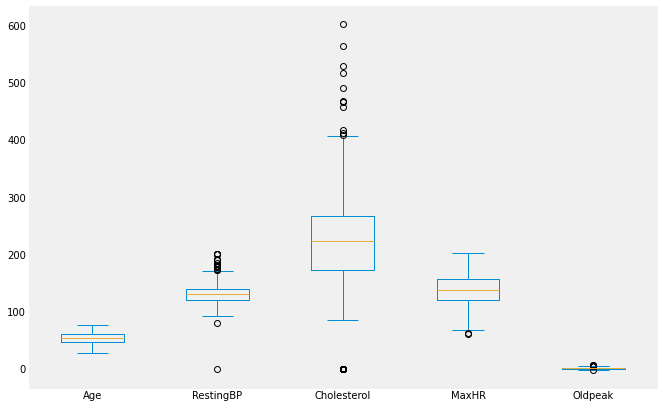

In [ ]:
#Melihat outlier
df[numerical_features].plot(kind="box", figsize=(10, 7))
plt.grid(False)
plt.show()

> **Insights:** 

Dari visualisasi box plot di atas:
* Semua distribusi `RestingBP`, `Cholesterol`, terlihat right-skewed

Diputuskan: tidak dibuang outliernya, karena outlier tersebut masih belum secara pasti disebabkan karena apa. Untuk itu, tetap menjaga data asli

In [ ]:
df.shape

(918, 12)

###2.2.3 Correlation

Melihat hubungan dari fitur numerik menggunakan correlation 

In [ ]:
df.corr()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
Age,1.000000,0.254399,-0.095282,-0.382045,0.258612
RestingBP,0.254399,1.000000,0.100893,-0.112135,0.164803
Cholesterol,-0.095282,0.100893,1.000000,0.235792,0.050148
MaxHR,-0.382045,-0.112135,0.235792,1.000000,-0.160691
Oldpeak,0.258612,0.164803,0.050148,-0.160691,1.000000


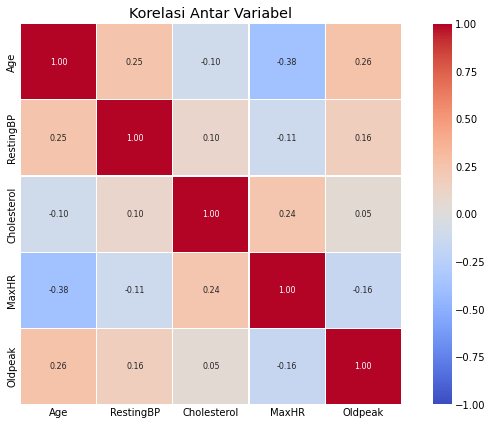

In [ ]:
# Visualisasikan correlation coefficient di atas dengan bantuan heat map
corr = df.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr, vmin=-1, vmax=1, cmap = "coolwarm", annot=True, annot_kws={"size":8}, fmt='.2f', linewidths=0.1, square = True)
plt.title("Korelasi Antar Variabel")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


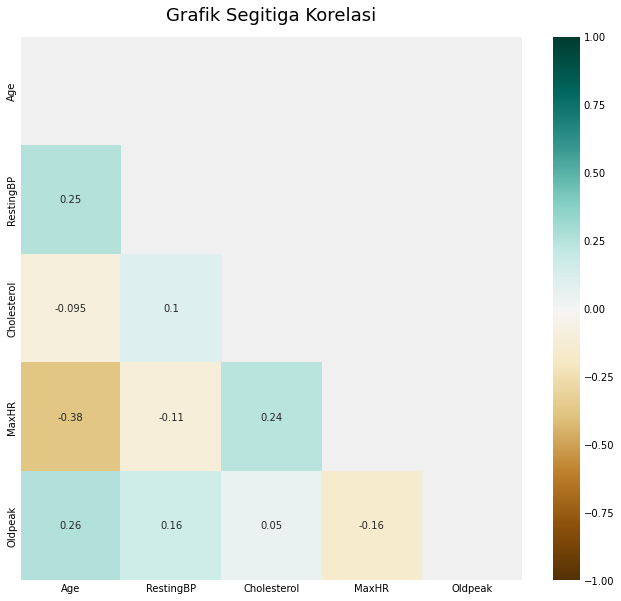

In [ ]:
# Grafik Heatmap 2
plt.figure(figsize=(10, 10))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Grafik Segitiga Korelasi', fontdict={'fontsize':18}, pad=16);


Dari visualisasi pada korelasi, terlihat bahwa tidak ada yang berkorelasi tinggi antara variabel satu dengan yang lainnya

##2.3 EDA Categorical

In [ ]:
df[categorical_features].head()

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease
0,M,ATA,0,Normal,N,Up,0
1,F,NAP,0,Normal,N,Flat,1
2,M,ATA,0,ST,N,Up,0
3,F,ASY,0,Normal,Y,Flat,1
4,M,NAP,0,Normal,N,Up,0


In [ ]:
#Number of Unique Values

df[categorical_features].nunique()

Sex               2
ChestPainType     4
FastingBS         2
RestingECG        3
ExerciseAngina    2
ST_Slope          3
HeartDisease      2
dtype: int64

In [ ]:
# menghitung/counting jumlah persebaran setiap Unique Value didalam setiap variabel
for feature in categorical_features:
    print(df[feature].value_counts())
    print ('------')

M    725
F    193
Name: Sex, dtype: int64
------
ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64
------
0    704
1    214
Name: FastingBS, dtype: int64
------
Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64
------
N    547
Y    371
Name: ExerciseAngina, dtype: int64
------
Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64
------
1    508
0    410
Name: HeartDisease, dtype: int64
------


###2.3.1 Visualisasi categorical

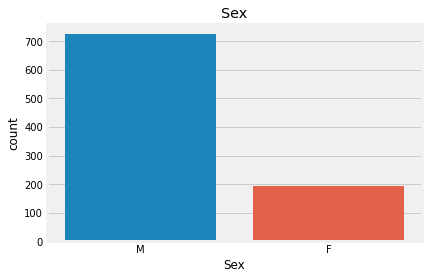

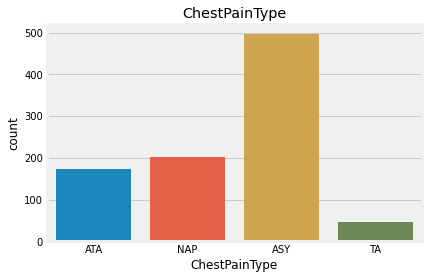

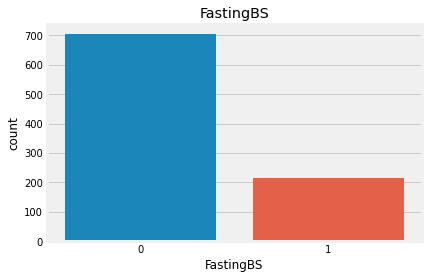

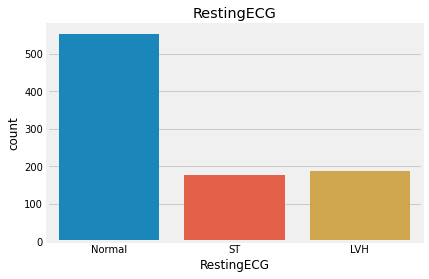

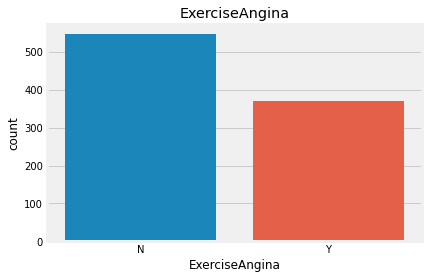

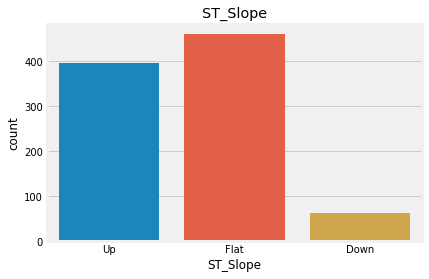

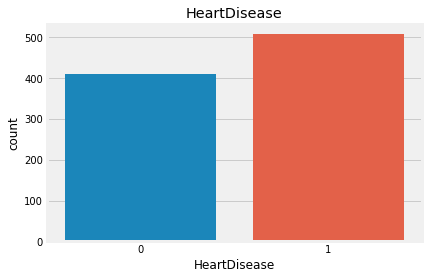

In [ ]:
df_categoric = df.loc[:, categorical_features]
for i in categorical_features:
    plt.figure()
    sns.countplot(x = i, data = df_categoric)
    plt.title(i)

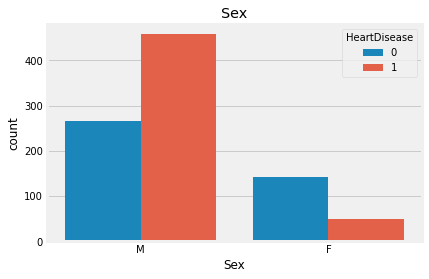

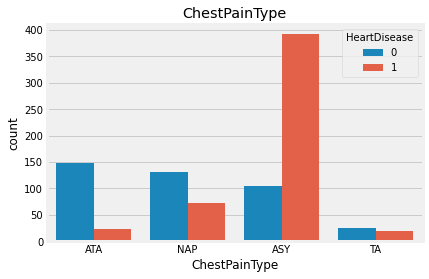

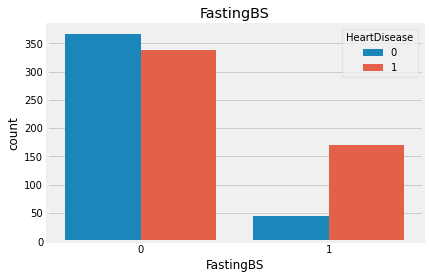

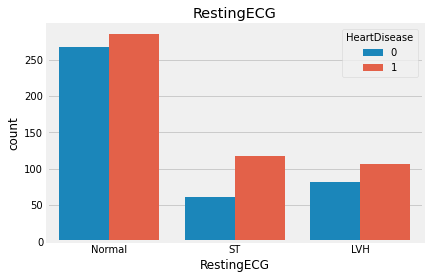

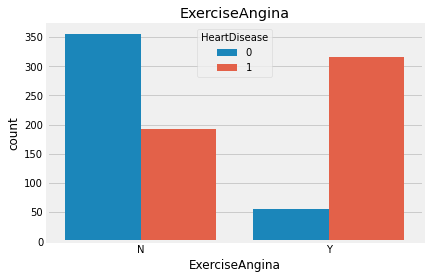

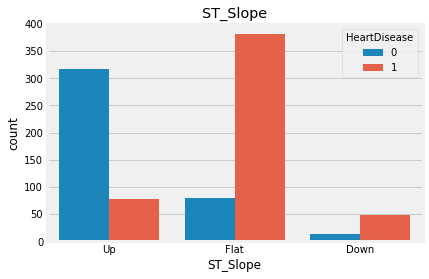

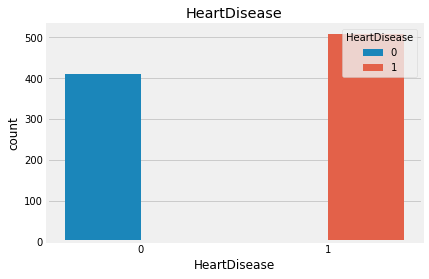

In [ ]:
#Visualisasi data yang berpatok kepada hue/variabel target 'HeartDisease'

df_categoric = df.loc[:, categorical_features]
for i in categorical_features:
    plt.figure()
    sns.countplot(x = i, data = df_categoric,hue = "HeartDisease")
    plt.title(i)

> **Insights Sex:** 


*   Dari visualisasi di atas, proporsi responden antara laki-laki dan perempuan lebih banyak responden laki-laki dibandingkan perempuan.
*    Selain itu, responden laki-laki yang mengalami penyakit jantung lebih banyak dibandingkan dengan responden laki-laki kondisi normal.
*   Pada responden perempuan dengan kondisi yang mengalami penyakit jantung lebih sedikit dibandingkan yang memiliki kondisi normal









> **Insights Chest Pain Type:**

*   Terlihat bahwa kebanyakan responden yang memiliki penyakit jantung dikarenakan nyeri dada ASY (tanpa gejala)
*   Selanjutnya disebabkan nyeri dada NAP (non-kardiak), nyeri dada ATA (atipikal), dan nyeri dada TA (Angina Pectoris)



> **Insights FastingBS:**

*   Dari visualisasi diatas, dapat disimpulkan bahwa responden yang memiliki FBS > 120 mg/dL dapat dikatakan normal atau tidak memiliki penyakit jantung.
*   Sedangkan responden yang memiliki FBS < 120 mg/dL lebih rentan mengalami penyakit jantung
*   FBS (FastingBS) adalah pemeriksaan untuk mengukur gula darah seseorang setelah puasa semalaman. Kadar gula darah puasa 99 mg/dL atau lebih rendah adalah normal, 100-125 mg/dL menunjukkan kamu memiliki pradiabetes, dan 126 mg/dL atau lebih tinggi menunjukkan kamu mengidap diabetes.





> **Insights Resting ECG:**


*   Berdasarkan visualisasi diatas, kebanyakan responden memiliki penyakit jantung dikarenakan RestingECG Normal yaitu berarti tidak terdapat kelainan aktivitas jantung pada saat pasien istirahat (dalam posisi berbaring)

> **Insights Exercise Angina:**

*  Berdasarkan data visualisasi diatas, responden yang memiliki penyakit jantung mengalami ExerciseAngina yaitu nyeri yang disebabkan ketika berolahraga dalam cuaca dingin.




> **Insights ST_Slope:**

*   Berdasarkan data visualisasi diatas, diketahui bahwa responden yang memiliki penyakit jantung dikarenakan ST Slope Flat. ST Slope merupakan peningkatan denyut jantung yang dipicu karena kegiatan berolahraga.



##2.4 Model Development

In [ ]:
df_for_modelling.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
#Mengubah data type FastingBS menjadi tipe data object
df_for_modelling['FastingBS'] = df_for_modelling['FastingBS'].astype('object')

In [ ]:
#Jika pemodelan, datanya perlu berupa numerik
df_for_modelling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    object 
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 86.2+ KB


Untuk memudahkan proses training, kita akan buat variabel `X` yang berisi semua fitur-fitur untuk melatih model dan variabel `y` yang berisi target variabel.

In [ ]:
#Menggunakan data modelling yang udah dibuat 

X = df_for_modelling.drop(columns=["HeartDisease"]).copy()
y = df_for_modelling["HeartDisease"].copy()

In [ ]:
y

0      0
1      1
2      0
3      1
4      0
      ..
913    1
914    1
915    1
916    1
917    0
Name: HeartDisease, Length: 918, dtype: int64

###2.4.1 Data Splitting

Seperti dijelaskan dalam slide, kita akan bagi dataset menjadi **training**, **dev validation**, dan **test** set dengan proporsi **80:10:10**.


In [ ]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=.2, stratify=y, random_state=101)
X_dev, X_test, y_dev, y_test = train_test_split(X_rest, y_rest, test_size=.5, stratify=y_rest, random_state=101)

print("training size:", X_train.shape[0])
print("dev size:", X_dev.shape[0])
print("test size:", X_test.shape[0])

print(f"training size: {X_train.shape[0]} ({100*X_train.shape[0] / X.shape[0]:.3f}%)")
print(f"dev size: {X_dev.shape[0]} ({100*X_dev.shape[0] / X.shape[0]:.3f}%)")
print(f"test size: {X_test.shape[0]} ({100*X_test.shape[0] / X.shape[0]:.3f}%)")

training size: 734
dev size: 92
test size: 92
training size: 734 (79.956%)
dev size: 92 (10.022%)
test size: 92 (10.022%)


> *Notes*. Parameter `stratify` di atas digunakan untuk mencegah nilai `y` yang tidak seimbang antara data training, dengan data development, dan data test.

Sehingga kita peroleh:
* data training sebanyak **734** baris
* data development sebanyak **92** baris
* data test sebanyak **92** baris

Untuk lebih jelasnya, kita bisa buat visualisasi distribusi target variabel `y` untuk masing-masing data

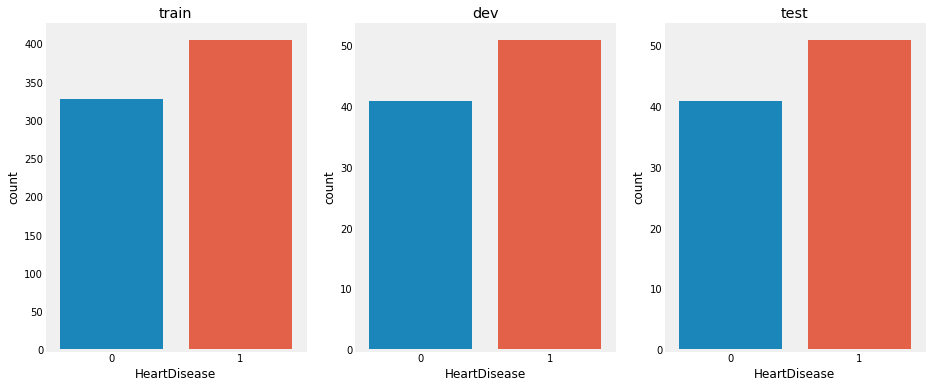

In [ ]:
fig, axis = plt.subplots(1, 3, figsize=(14, 6))
for idx, label in enumerate([
    (y_train, "train"), (y_dev, "dev"), (y_test, "test")
]):
    sns.countplot(x=label[0], ax=axis[idx])
    axis[idx].set_title(label[1])
    axis[idx].grid(False)
plt.show()

In [ ]:
X_train

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
88,43,M,TA,120,291,0,ST,155,N,0.0,Flat
204,56,M,ATA,130,184,0,Normal,100,N,0.0,Up
83,52,M,ATA,160,196,0,Normal,165,N,0.0,Up
811,58,F,ASY,100,248,0,LVH,122,N,1.0,Flat
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up
...,...,...,...,...,...,...,...,...,...,...,...
383,38,F,ASY,110,0,0,Normal,156,N,0.0,Flat
820,52,M,TA,152,298,1,Normal,178,N,1.2,Flat
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat
519,63,M,ASY,96,305,0,ST,121,Y,1.0,Up


###2.4.2 Encoding Categorical Features

Fitur **kategorik nominal**, yaitu `Race` dan `Sex` akan diubah menjadi matriks one-hot encoding, sedangkan fitur **kategorik ordinal** (sisa fitur kategorik lainnya) akan diubah ke dalam bentuk angka terurut.

In [ ]:
nominal_features = ["Sex", "ChestPainType", "ST_Slope"]
ordinal_features = X.select_dtypes(
    include="object"
).drop(columns=nominal_features).columns.tolist()

print("nominal features:", nominal_features)
print("ordinal features:")
pprint(ordinal_features, compact=True)

nominal features: ['Sex', 'ChestPainType', 'ST_Slope']
ordinal features:
['FastingBS', 'RestingECG', 'ExerciseAngina']


In [ ]:
# Fungsi OHE untuk Categorical Encoding
onehot = OneHotEncoder()
onehot.fit(X_train[nominal_features])
X_train_onehot = pd.DataFrame(
    onehot.transform(X_train[nominal_features]).toarray(),
    columns=onehot.get_feature_names_out()
)
X_dev_onehot = pd.DataFrame(
    onehot.transform(X_dev[nominal_features]).toarray(),
    columns=onehot.get_feature_names_out()
)
X_test_onehot = pd.DataFrame(
    onehot.transform(X_test[nominal_features]).toarray(),
    columns=onehot.get_feature_names_out()
)
print("one-hot matrix:")
display(X_train_onehot)

ordinal = OrdinalEncoder()
ordinal.fit(X_train[ordinal_features])
X_train_ordinal = pd.DataFrame(
    ordinal.transform(X_train[ordinal_features]),
    columns=ordinal.feature_names_in_
)
X_dev_ordinal = pd.DataFrame(
    ordinal.transform(X_dev[ordinal_features]),
    columns=ordinal.feature_names_in_
)
X_test_ordinal = pd.DataFrame(
    ordinal.transform(X_test[ordinal_features]),
    columns=ordinal.feature_names_in_
)
print("ordinal matrix:")
display(X_train_ordinal)

one-hot matrix:


,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
729,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
730,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
731,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
732,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


ordinal matrix:


,FastingBS,RestingECG,ExerciseAngina
0,0.0,2.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,0.0
4,0.0,1.0,0.0
...,...,...,...
729,0.0,1.0,0.0
730,1.0,1.0,0.0
731,0.0,1.0,1.0
732,0.0,2.0,1.0


###2.4.3 Data Rescalling


Kita akan menggunakan function `StandardScaler` dari `scikit-learn` sedemikian hingga nilai fitur-fitur numerik memiliki rata-rata 0 dan standar deviasi 1.

Tapi, sebelum itu, kita akan gabungan fitur numerik yang dengan fitur kategorik yang sudah diubah ke dalam bentuk numerik.

> Perlu diperhatikan, untuk mencegah **data leakage**, kita akan melakukan `fit` pada data training saja.

> _Data leakage refers to **a mistake make by the creator of a machine learning model in which they accidentally share information between the test and training data-sets**_ ([ref](https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742)).

In [ ]:
X_train_combined = pd.concat(
    [X_train[numerical_features].reset_index(drop=True), X_train_onehot, X_train_ordinal],
    axis=1
)
X_dev_combined = pd.concat(
    [X_dev[numerical_features].reset_index(drop=True), X_dev_onehot, X_dev_ordinal],
    axis=1
)
X_test_combined = pd.concat(
    [X_test[numerical_features].reset_index(drop=True), X_test_onehot, X_test_ordinal],
    axis=1
)

X_train_combined.head()

# concat = menggabungkan data variabel kategorik & numerik untuk nantinya training, testing, validation data

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,FastingBS,RestingECG,ExerciseAngina
0,43,120,291,155,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0
1,56,130,184,100,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,52,160,196,165,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,58,100,248,122,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,45,130,237,170,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Kemudian, kita akan mulai melakukan _rescaling_.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_combined)

X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_combined),
    columns=X_train_combined.columns
)
X_dev_scaled = pd.DataFrame(
    scaler.transform(X_dev_combined),
    columns=X_dev_combined.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_combined),
    columns=X_test_combined.columns
)

with pd.option_context("display.max_columns", None):
    display(X_train_scaled.head())

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,FastingBS,RestingECG,ExerciseAngina
0,-1.116659,-0.648106,0.845479,0.739554,-0.847637,-0.504679,0.504679,-1.106455,-0.487621,-0.519515,4.608950,-0.267456,1.016485,-0.888957,-0.553218,1.602009,-0.850297
1,0.278543,-0.120068,-0.118843,-1.414388,-0.847637,-0.504679,0.504679,-1.106455,2.050774,-0.519515,-0.216969,-0.267456,-0.983783,1.124914,-0.553218,0.000000,-0.850297
2,-0.150750,1.464048,-0.010695,1.131179,-0.847637,-0.504679,0.504679,-1.106455,2.050774,-0.519515,-0.216969,-0.267456,-0.983783,1.124914,-0.553218,0.000000,-0.850297
3,0.493190,-1.704183,0.457948,-0.552811,0.107630,1.981458,-1.981458,0.903787,-0.487621,-0.519515,-0.216969,-0.267456,1.016485,-0.888957,-0.553218,-1.602009,-0.850297
4,-0.902012,-0.120068,0.358812,1.326992,-0.847637,1.981458,-1.981458,-1.106455,2.050774,-0.519515,-0.216969,-0.267456,-0.983783,1.124914,-0.553218,0.000000,-0.850297


* Setelah kita melakukan rescaling terhadap data, tahap selanjutnya yaitu kita akan masuk dalam tahap membangun pemodelan (*Modeling*)

###2.4.4 Modelling

####2.4.4.1 Decision Tree Method

* Kita akan menggunakan `DecisionTreeClassifier` dari `scikit-learn`. Ada beberapa [(hyper)parameter](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) yang bisa kita tentukan saat mendefisinikan model.

* Sebagai awalan, kita akan menggunakan _default_ parameter yang disediakan oleh `scikit-learn` apa adanya.

In [ ]:
X_train_scaled

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,FastingBS,RestingECG,ExerciseAngina
0,-1.116659,-0.648106,0.845479,0.739554,-0.847637,-0.504679,0.504679,-1.106455,-0.487621,-0.519515,4.608950,-0.267456,1.016485,-0.888957,-0.553218,1.602009,-0.850297
1,0.278543,-0.120068,-0.118843,-1.414388,-0.847637,-0.504679,0.504679,-1.106455,2.050774,-0.519515,-0.216969,-0.267456,-0.983783,1.124914,-0.553218,0.000000,-0.850297
2,-0.150750,1.464048,-0.010695,1.131179,-0.847637,-0.504679,0.504679,-1.106455,2.050774,-0.519515,-0.216969,-0.267456,-0.983783,1.124914,-0.553218,0.000000,-0.850297
3,0.493190,-1.704183,0.457948,-0.552811,0.107630,1.981458,-1.981458,0.903787,-0.487621,-0.519515,-0.216969,-0.267456,1.016485,-0.888957,-0.553218,-1.602009,-0.850297
4,-0.902012,-0.120068,0.358812,1.326992,-0.847637,1.981458,-1.981458,-1.106455,2.050774,-0.519515,-0.216969,-0.267456,-0.983783,1.124914,-0.553218,0.000000,-0.850297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,-1.653275,-1.176144,-1.777117,0.778716,-0.847637,1.981458,-1.981458,0.903787,-0.487621,-0.519515,-0.216969,-0.267456,1.016485,-0.888957,-0.553218,0.000000,-0.850297
730,-0.150750,1.041617,0.908566,1.640293,0.298684,-0.504679,0.504679,-1.106455,-0.487621,-0.519515,4.608950,-0.267456,1.016485,-0.888957,1.807607,0.000000,-0.850297
731,0.385866,-0.120068,-0.596498,-0.826949,0.298684,-0.504679,0.504679,0.903787,-0.487621,-0.519515,-0.216969,-0.267456,1.016485,-0.888957,-0.553218,0.000000,1.176060
732,1.029806,-1.915398,0.971652,-0.591974,0.107630,-0.504679,0.504679,0.903787,-0.487621,-0.519515,-0.216969,-0.267456,-0.983783,1.124914,-0.553218,1.602009,1.176060


In [ ]:
# Panggil function DecisionTreeClassifier() dari scikit-learn
model_default = DecisionTreeClassifier(random_state=11)

# Terapkan model tersebut menggunakan funciton fit() untuk membuat model berdasarkan set training
model_default.fit(X_train_scaled, y_train)


preds_train = model_default.predict(X_train_scaled) # training data
preds_dev = model_default.predict(X_dev_scaled) # validation data
preds_test = model_default.predict(X_test_scaled) # testing data

In [ ]:
#Training set
print("train prediction samples:\n", preds_train[:20])
print("train target samples:\n", y_train[:20].tolist())

train prediction samples:
 [1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1]
train target samples:
 [1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]


In [ ]:
#Development tes
print("dev prediction samples:\n", preds_dev[:20])
print("dev target samples:\n", y_dev[:20].tolist())

dev prediction samples:
 [1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1]
dev target samples:
 [1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1]


In [ ]:
#Prediction tes
print("test prediction samples:\n", preds_test[:20])
print("test target samples:\n", y_test[:20].tolist())

test prediction samples:
 [1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 0 1]
test target samples:
 [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]


Kita bisa membuat visualisasi model Decision Tree yang sudah dilatih supaya kita bisa melihat bagaimana model bisa melakukan prediksi dan fitur-fitur mana yang menjadi root node ataupun decision node.

> karena kita menggunakan hyperparameter default model, proses visualisasi model mungkin akan memakan waktu yang cukup lama untuk seluruh level. Oleh karena itu, kita akan coba visualisasi 5 level pertama model saja.

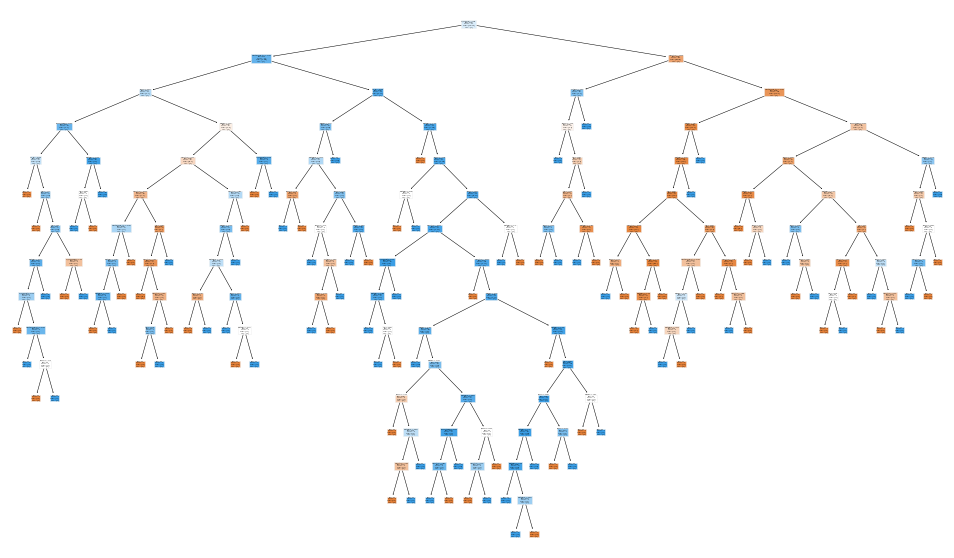

In [ ]:
# visualisasi decision tree dari model Heart Diseases pada kedalaman 5 level
plt.figure(figsize=(15, 10))
plot_tree(
    model_default,
    feature_names=model_default.feature_names_in_,
    class_names=True,
    filled=True,
)
plt.show()

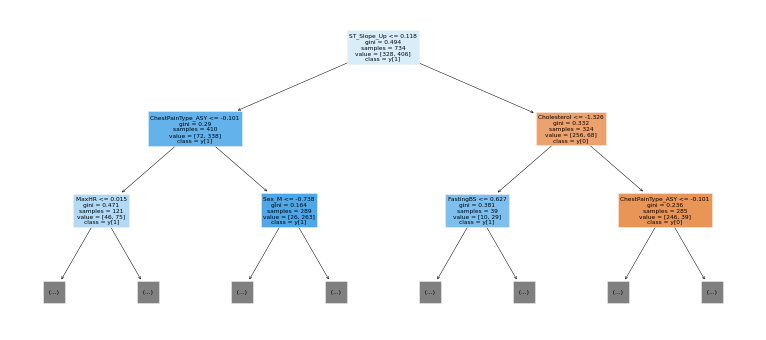

In [ ]:
# visualisasi decision tree dari model Heart Diseases pada kedalaman 2 level
plt.figure(figsize=(12, 6))
plot_tree(model_default,feature_names = rf.feature_names_in_,  max_depth=2, class_names=True,
    filled=True,)
plt.show()

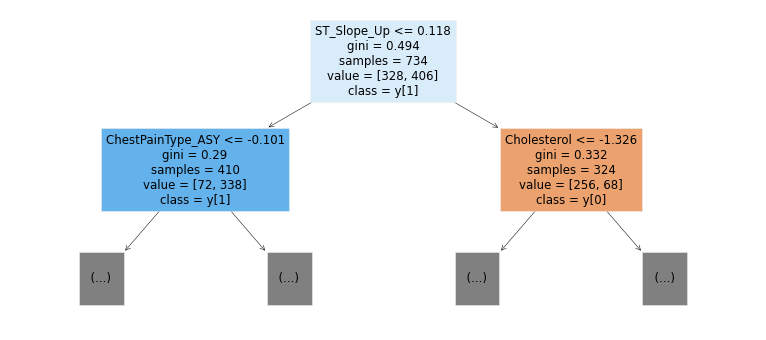

In [ ]:
# visualisasi decision tree dari model Heart Diseases pada kedalaman 1 level
plt.figure(figsize=(12, 6))
plot_tree(model_default, feature_names = model_default.feature_names_in_,  max_depth=1, class_names=True,
    filled=True)
plt.show()

Keterangan class :  

> y[1] = **Heart Disease**

> y[0] = **Normal**

##### 2.4.4.1.1 Model Evaluation Decision Tree

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       328
           1       1.00      1.00      1.00       406

    accuracy                           1.00       734
   macro avg       1.00      1.00      1.00       734
weighted avg       1.00      1.00      1.00       734



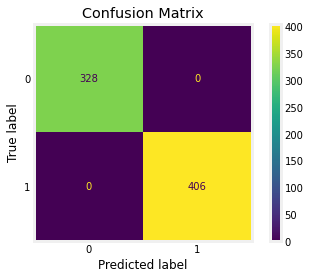

In [ ]:
print(classification_report(y_train, preds_train))

ConfusionMatrixDisplay.from_predictions(y_train, preds_train)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

Insights yang diperoleh dari evaluasi model pada data training adalah:
* semua **evaluation metrics sudah bagus**, mulai dari **accuracy**, **precision**, **recall**, dan **f1-score**
* dari 328 data yang berlabel 0 atau "No" **, model tidak gagal satupun untuk memprediksi. Ini berarti, ada 238 atau **100%** orang yang tidak memiliki riwayat penyakit jantung atau normal

              precision    recall  f1-score   support

           0       0.83      0.85      0.84        41
           1       0.88      0.86      0.87        51

    accuracy                           0.86        92
   macro avg       0.86      0.86      0.86        92
weighted avg       0.86      0.86      0.86        92



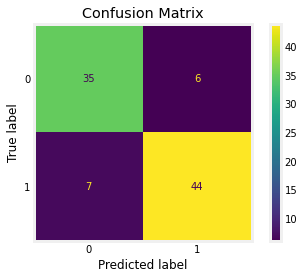

In [ ]:
print(classification_report(y_dev, preds_dev))

ConfusionMatrixDisplay.from_predictions(y_dev, preds_dev)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

              precision    recall  f1-score   support

           0       0.74      0.71      0.72        41
           1       0.77      0.80      0.79        51

    accuracy                           0.76        92
   macro avg       0.76      0.76      0.76        92
weighted avg       0.76      0.76      0.76        92



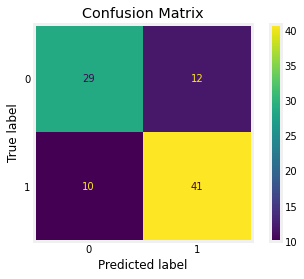

In [ ]:
print(classification_report(y_test, preds_test))

ConfusionMatrixDisplay.from_predictions(y_test, preds_test)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

Evaluation metrics udah bagus, dlihat dari accuray, precision dan f1 score 

> Dari 51 yang berlabel "1" (Heart Disease), model gagal memprediksi 13 data dengan benar. Ini berarti, seharusnya 10 orang terkena penyakit jantung, tetapi model mengatakan orang tersebut sehat



####2.4.4.2 Random Forest Method



In [ ]:
# For New ML models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [ ]:
rf = RandomForestClassifier(random_state=11)
rf.fit(X_train_scaled, y_train)

#y_pred = rf.predict(X_dev_scaled)
preds_train_rf = rf.predict(X_train_scaled) # training data
preds_dev_rf = rf.predict(X_dev_scaled) # validation data
preds_test_rf = rf.predict(X_test_scaled) # testing data


In [ ]:
print("training prediction samples:\n", preds_train_rf[:20])
print("training target samples:\n", y_test[:20].tolist())

training prediction samples:
 [0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0]
training target samples:
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]


In [ ]:
print("dev prediction samples:\n", preds_dev_rf[:20])
print("dev target samples:\n", y_test[:20].tolist())

dev prediction samples:
 [1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0]
dev target samples:
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]


In [ ]:
print("test prediction samples:\n", preds_test_rf[:20])
print("test target samples:\n", y_test[:20].tolist())

test prediction samples:
 [1 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0]
test target samples:
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]


In [ ]:
print(len(rf.estimators_))

100


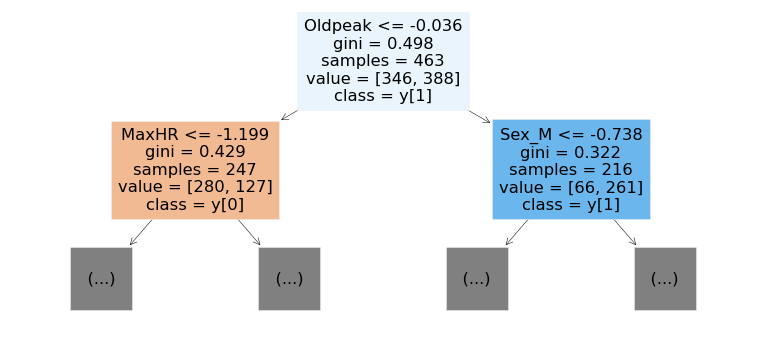

In [ ]:
plt.figure(figsize=(12, 6))
tree.plot_tree(rf.estimators_[0],
               feature_names = rf.feature_names_in_, 
               max_depth = 1,
               class_names= True,
               filled = True);

Keterangan class :  

> y[1] = **Heart Disease**

> y[0] = **Normal**

#####2.4.4.2.1 Model Evaluation Random Forest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       328
           1       1.00      1.00      1.00       406

    accuracy                           1.00       734
   macro avg       1.00      1.00      1.00       734
weighted avg       1.00      1.00      1.00       734



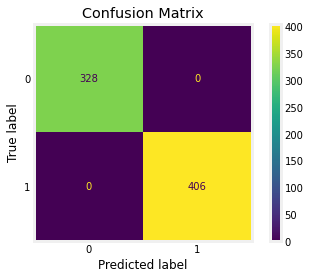

In [ ]:
print(classification_report(y_train, preds_train_rf))

ConfusionMatrixDisplay.from_predictions(y_train, preds_train_rf)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        41
           1       0.98      0.92      0.95        51

    accuracy                           0.95        92
   macro avg       0.94      0.95      0.95        92
weighted avg       0.95      0.95      0.95        92



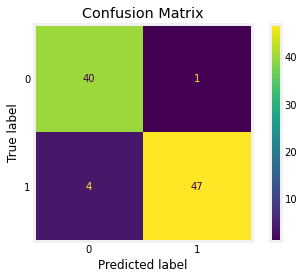

In [ ]:
print(classification_report(y_dev, preds_dev_rf))

ConfusionMatrixDisplay.from_predictions(y_dev, preds_dev_rf)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        41
           1       0.90      0.90      0.90        51

    accuracy                           0.89        92
   macro avg       0.89      0.89      0.89        92
weighted avg       0.89      0.89      0.89        92



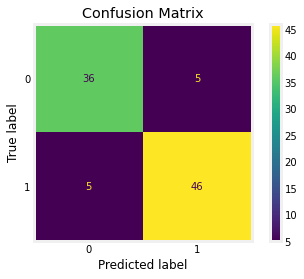

In [ ]:
print(classification_report(y_test, preds_test_rf))

ConfusionMatrixDisplay.from_predictions(y_test, preds_test_rf)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()